In [20]:
!pip install scikit-commpy

Travaux pratiques pour modéliser un système de communication

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.channels import awgn
from commpy.filters import  rrcosfilter, rcosfilter

In [54]:
M = 4               # Size of the signal constellation
k = int(np.log2(M)) # Number of bits per symbol
sps = 100           # Samples per symbol
N = 1000             # Number of data bits

alpha = 0.35
sps = 100
nTaps = 1000
ts = 1
fs = sps / ts

Constantes

Transmitter
To do :
1. Allocate data to each level ([1, -1] or [1,0.33,-0.33,-1])
2. Upsample with zeros
2. Generate pulse (RRC) and plot
3. Apply pulse shapping (convolve)
4. Plot

In [55]:
def convertLevel(numberLevel, N, k):
    data = np.random.randint(M, size=int(N/k))
    mapping = {
        0: 1,
        1: 0.33,
        2: -0.33,
        3: -1
    }


    if numberLevel == 2:
      dataReturn = np.where(data == 0, -1, 1)

    elif numberLevel == 4:
      dataReturn = np.array([mapping[val] for val in data])
    else :
      print("Number of level not supported")
      return None

    return dataReturn


def upSsample(data, sps, mode):

    if mode == 0:
        data_up = np.zeros(len(data) * (sps + 1) - sps)
        data_up[::sps + 1] = data
        data = data_up
    elif mode == 1:
      data = np.repeat(data, sps)
    return data

myDatas = upSsample(convertLevel(M, N, k), sps, 1) / sps





[-0.0033 -0.0033 -0.0033 ... -0.0033 -0.0033 -0.0033]


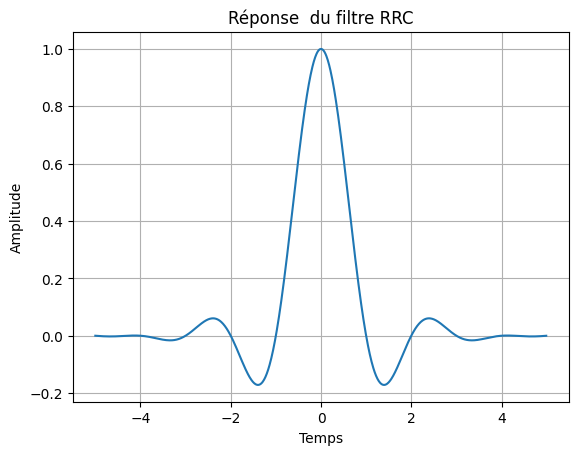

In [56]:
print(myDatas)
time, dataFiltered = rcosfilter(nTaps, alpha, 1,sps)


plt.plot(time, dataFiltered)
plt.title('Réponse  du filtre RRC')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()




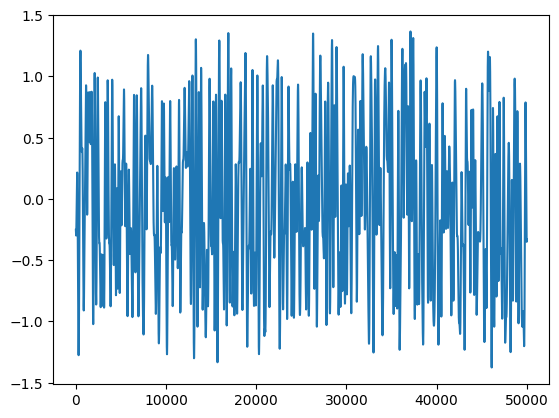

In [57]:
#Show convolution

txSig = np.convolve(myDatas, dataFiltered, mode="same")
plt.plot(txSig)

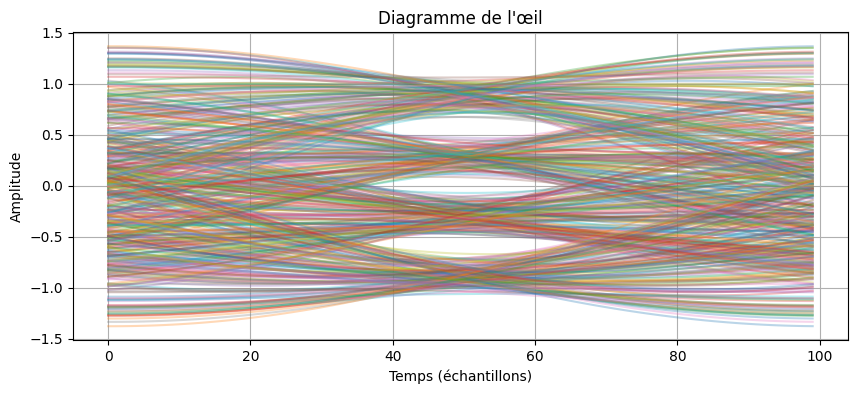

In [59]:
#Eye diagram
eyeData = []
num_eyes = 50

def plot_eye_diagram(signal, sps, n_periods=1):
    samples_per_period = sps
    n_symbols = len(signal) // samples_per_period
    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(n_symbols - n_periods):
        segment = signal[i * samples_per_period:(i + n_periods) * samples_per_period]
        ax.plot(segment, alpha=0.3)

    ax.set_title("Diagramme de l'œil")
    ax.set_xlabel("Temps (échantillons)")
    ax.set_ylabel("Amplitude")
    plt.grid(True)
    plt.show()

plot_eye_diagram(txSig, sps)

Channel

In [11]:
EbNo = 25;   #en dB
snr = EbNo + 10*np.log10(k) - 10*np.log10(0.5*sps); #snr: S/N per sample in dB
rxSig = awgn(txSig, snr)

Receiver
To do:
1. Apply RRC again
2. Take a sample every Tb
3. Decide if it is [1, -1] (M=2) or [1,0.33,-0.33,1] (M=4)

In [12]:
def decide(samples, M):
    """
    Cette fonction prend une décision en fonction des niveaux de modulation.
    Elle utilise np.digitize pour classer les échantillons.
    """
    if M == 2:
        levels = [-1, 1]
        thresholds = [0]
        decisions = np.digitize(samples, thresholds)
        return np.array([levels[decision] for decision in decisions])

    elif M == 4:
        levels = [-1, -0.33, 0.33, 1]
        thresholds = [-0.5, 0, 0.5]
        decisions = np.digitize(samples, thresholds)
        return np.array([levels[decision] for decision in decisions])

    else:
        raise ValueError("Modulation M non supportée")

def interpret(samples, M):
    """
    Cette fonction interprète les symboles en bits selon la modulation M-aire.
    """
    if M == 2:
        return np.where(samples < 0, 0, 1)

    elif M == 4:
        levels = [-1, -0.33, 0.33, 1]
        return np.digitize(samples, [-0.5, 0, 0.5])

    else:
        raise ValueError("Modulation M non supportée")


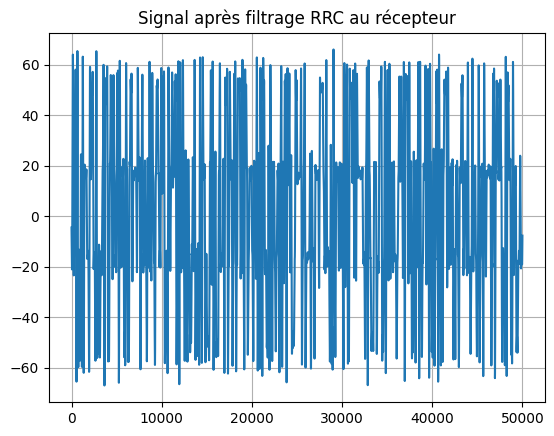

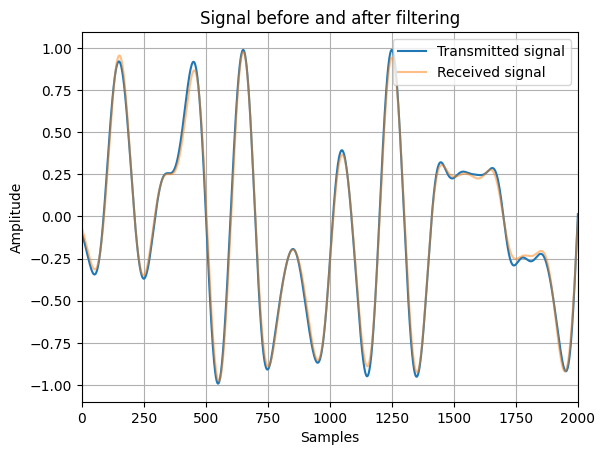

In [13]:

t, rrc_pulse = rrcosfilter(nTaps, alpha, ts, sps)


rrc_pulse = rrc_pulse / np.sum(rrc_pulse)


filtered_rxSig = np.convolve(rxSig, rrc_pulse, mode='same')


plt.plot(filtered_rxSig)
plt.title('Signal après filtrage RRC au récepteur')
plt.grid(True)
plt.show()


txSig_normalized = txSig / np.max(np.abs(txSig))
rxSig_normalized = filtered_rxSig / np.max(np.abs(filtered_rxSig))


plt.figure()
plt.plot(txSig_normalized, label='Transmitted signal')
plt.plot(rxSig_normalized, label='Received signal', alpha=0.5)
plt.title('Signal before and after filtering')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.xlim(0, 20 * sps)
plt.legend()
plt.grid(True)
plt.show()





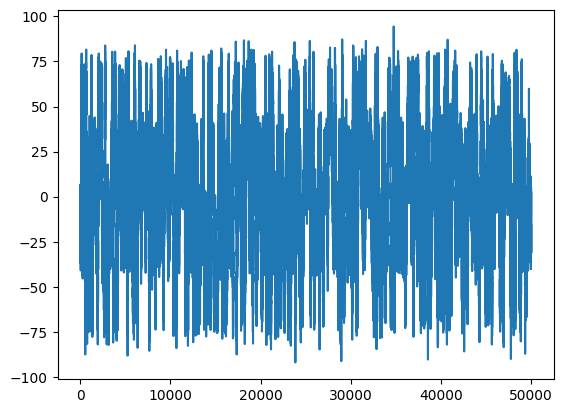

In [14]:
plt.plot(rxSig)

BER
To do:
1. Compare input with output, compute BER
2. Add a loop to vary Eb/N0 from 0 to 10dB by step of 0.1 dB
3. Plot BER vs. Eb/N0 curve

In [18]:
from scipy.special import erfc

def compute_ber_ask(Eb_N0_dB, M):
    Eb_N0 = 10**(Eb_N0_dB / 10)  # Convertir Eb/N0 de dB en échelle linéaire
    k = np.log2(M)  # Nombre de bits par symbole
    return (1/k) * ((M - 1) / M) * erfc(np.sqrt((3 / (M**2 - 1)) * Eb_N0 * k))



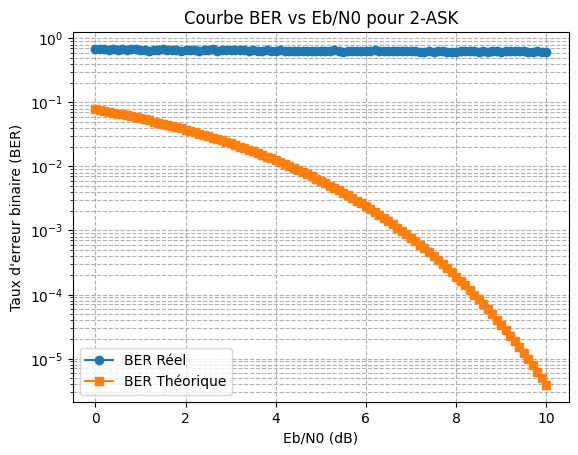

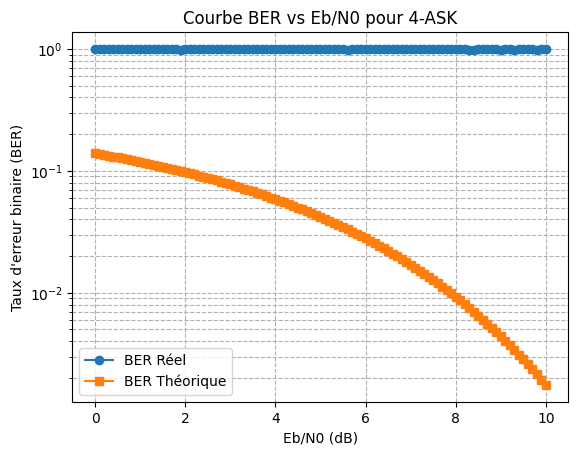

In [19]:
import matplotlib.pyplot as plt
import numpy as np


# Boucle pour calculer le BER pour M = 2 et M = 4
Eb_N0_dB_range = np.arange(0, 10.1, 0.1)
for M in [2, 4]:
    BER_real = []
    BER_theoretical = []

    k = int(np.log2(M))

    data_tx = convertLevel(M, N, k)


    upsampled_data = upSsample(data_tx, sps, mode=1)


    t_rrc, rrc_pulse = rrcosfilter(nTaps, alpha, ts/2, sps)
    txSig = np.convolve(upsampled_data, rrc_pulse, mode='same')

    for Eb_N0_dB in Eb_N0_dB_range:

        snr = Eb_N0_dB + 10*np.log10(k) - 10*np.log10(0.5 * sps)  #
        channelSig = awgn(txSig, snr)

        rxSig = np.convolve(channelSig, rrc_pulse, mode='same')

        rxSig = rxSig / (sps / 2)

        downsampled_data = rxSig[::sps]

        data_decide = decide(downsampled_data, M)

        data_rx = interpret(data_decide, M)

        min_length = min(len(data_rx), len(data_tx))


        data_rx = data_rx[:min_length]
        data_tx = data_tx[:min_length]

        bit_errors = np.sum(np.array(data_rx) != data_tx)
        ber_real = bit_errors / len(data_tx)
        BER_real.append(ber_real)


        ber_theoretical = compute_ber_ask(Eb_N0_dB, M)
        BER_theoretical.append(ber_theoretical)

    # Tracer les courbes BER vs. Eb/N0
    plt.figure()
    plt.semilogy(Eb_N0_dB_range, BER_real, label='BER Réel', marker='o')
    plt.semilogy(Eb_N0_dB_range, BER_theoretical, label='BER Théorique', marker='s')
    plt.title('Courbe BER vs Eb/N0 pour {}-ASK'.format(M))
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taux d\'erreur binaire (BER)')
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()


In [ ]:
Il y a des soucis dans le code qui fait que les calculs ne sont pas corrects mais je ne sais pas ou